In [1]:
import torch 
import numpy as np 
import math 
import sys
from tqdm import tqdm 
import matplotlib.pyplot as plt
import pickle 
import os
from inference_util.utils import parse_args 
from inference_util.utils import load_fp_model, load_graph_model

## fsmol test result

#### fsmol

In [3]:
from EDKT_data.Data_FP_fsmol import deep_gp_data as deep_gp_data_fp
from EDKT_data.Data_Graph_fsmol import deep_gp_data as deep_gp_data_graph

assay_id_train_test_split = np.load('../Data_for_publication/fsmol_multifp/split_dic.pkl', allow_pickle=True)
test_assay_ls = assay_id_train_test_split['test_assays']
eval_assay_ls = assay_id_train_test_split['valid_assays']

few_shot_number = 128

model_args = [
    "--encode_method", "FPaugment",
]
args_fp = parse_args(model_args)

# load fp data
data_path = '../Data_for_publication/fsmol_multifp/all_data_fp.pkl'
data_path_test = f'../Data_for_publication/fsmol_multifp/all_data_fp_test_10fold_{few_shot_number}.pkl'
data_path_valid = f'../Data_for_publication/fsmol_multifp/all_data_fp_valid_10fold_{few_shot_number}.pkl'
data_test_fp = deep_gp_data_fp(data_path, data_path_test, args_fp)
data_valid_fp = deep_gp_data_fp(data_path, data_path_valid, args_fp)

# load graph data
data_path = '../Data_for_publication/fsmol_multifp/all_data_graph.pkl'
data_path_test = f'../Data_for_publication/fsmol_multifp/all_data_graph_test_10fold_{few_shot_number}.pkl'
data_path_valid = f'../Data_for_publication/fsmol_multifp/all_data_graph_valid_10fold_{few_shot_number}.pkl'
data_test_graph = deep_gp_data_graph(data_path, data_path_test)
data_valid_graph = deep_gp_data_graph(data_path, data_path_valid)

### load model

In [3]:
model_args = [
    "--num_encoder", "50",
    "--dataset", "fsmol",
    "--encode_method", "FP",
    "--random_seed", "42",
]

args_fp = parse_args(model_args)
fp_model = load_fp_model(args_fp)

/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


✓ FP Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:FP_Num:50_NCL:False_seed:42.pth


In [4]:
model_args = [
    "--num_encoder", "2",
    "--dataset", "fsmol",
    "--encode_method", "GraphGAT",
    "--random_seed", "0",
]
args_graph = parse_args(model_args)
graph_model = load_graph_model(args_graph)

✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphGAT_Num:2_NCL:False_seed:0.pth


/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


#### Utils functions

In [2]:
def get_model_performance_overall_fp(assay_ls, model, folde_id, mode = 'test'):
    r2_ls = []
    for assay_id in assay_ls:
        if mode == 'test':
            task_data = data_test_fp.tensorize_test(assay_id, folde_id)
        elif mode == 'valid':
             task_data = data_valid_fp.tensorize_test(assay_id, folde_id)
        prediction = model.prediction(task_data, 'cpu')
        y_label = task_data[3]
        r2 = np.corrcoef(torch.tensor(y_label).reshape(-1), prediction.detach().cpu().numpy().reshape(-1))[0,1]**2
        r2_ls.append(r2)
    return r2_ls

def get_model_performance_overall_graph(assay_ls, model, folde_id, mode = 'test'):
    r2_ls = []
    for assay_id in assay_ls:
        if mode == 'test':
            task_data = data_test_graph.smiles_to_graph_test(assay_id, folde_id)
        elif mode == 'valid':
             task_data = data_valid_graph.smiles_to_graph_test(assay_id, folde_id)
        prediction = model.prediction(task_data, 'cpu')
        y_label = task_data[3]
        r2 = np.corrcoef(torch.tensor(y_label).reshape(-1), prediction.detach().cpu().numpy().reshape(-1))[0,1]**2
        r2_ls.append(r2)
    return r2_ls

In [6]:
def get_prediction_dict_per_model(assay_ls, device, fold_id, mode = 'valid'):
    # graph model prediction, first load then predict
    for model_architecture in ['GraphGCN', 'GraphSAGE']:
    # for model_architecture in ['GraphGCN', 'GraphGAT', 'GraphGIN', 'GraphSAGE']:
        prediction_dic = {}
        for random_seed in range(20):
            model_args = [
                "--num_encoder", "2",
                "--dataset", "fsmol",
                "--encode_method", model_architecture,
                "--random_seed", str(random_seed),
            ]
            args_graph = parse_args(model_args)
            graph_model = load_graph_model(args_graph)
            if graph_model is None:
                continue
            graph_model.eval()
            with torch.no_grad():
                graph_model.to(device)
                for assay_id in assay_ls:
                    if assay_id not in prediction_dic:
                        prediction_dic[assay_id] = dict()
                        prediction_dic[assay_id]['prediction'] = []
                        prediction_dic[assay_id]['variance'] = []
                    if mode == 'test':
                        # task_data_fp = data_test_fp.tensorize_test(assay_id, fold_id)
                        task_data_graph = data_test_graph.smiles_to_graph_test(assay_id, fold_id)
                    elif mode == 'valid':
                        # task_data_fp = data_valid_fp.tensorize_test(assay_id, fold_id)
                        task_data_graph = data_valid_graph.smiles_to_graph_test(assay_id, fold_id)
                    result_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate(task_data_graph, device)]
                    variance_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate_var(task_data_graph, device)]
                    prediction_dic[assay_id]['prediction'].extend(result_ls)
                    prediction_dic[assay_id]['variance'].extend(variance_ls)
                    torch.cuda.empty_cache()
        with open(f'../Result_for_publication/fsmol/{few_shot_number}/Fold_{fold_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
            pickle.dump(prediction_dic, f)
    # FP model prediction, first load then predict
#     model_architecture = 'FPaugment'
#     model_args = [
#     "--num_encoder", "50",
#     "--dataset", "fsmol",
#     "--encode_method", model_architecture,
#     "--random_seed", "0",
# ]
#     args_fp = parse_args(model_args)
#     fp_model = load_fp_model(args_fp).to(device)
#     fp_model.eval()
#     prediction_dic = {}
#     label_dic = {}
#     with torch.no_grad():
#         for assay_id in assay_ls:
#             if mode == 'test':
#                 task_data_fp = data_test_fp.tensorize_test(assay_id, fold_id)
#                 # task_data_graph = data_test_graph.smiles_to_graph_test(assay_id, fold_id)
#             elif mode == 'valid':
#                 task_data_fp = data_valid_fp.tensorize_test(assay_id, fold_id)
#                 # task_data_graph = data_valid_graph.smiles_to_graph_test(assay_id, fold_id)
#             result_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate(task_data_fp, device)]
#             variance_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate_var(task_data_fp, device)]
#             prediction_dic[assay_id] = dict()
#             prediction_dic[assay_id]['prediction'] = result_ls
#             prediction_dic[assay_id]['variance'] = variance_ls
#             label_dic[assay_id] = task_data_fp[3].numpy()
#             torch.cuda.empty_cache()
#     with open(f'../Result_for_publication/fsmol/{few_shot_number}/Fold_{fold_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
#         pickle.dump(prediction_dic, f)
#     with open(f'../Result_for_publication/fsmol/{few_shot_number}/Fold_{fold_id}/{mode}_label_dic.pkl', 'wb') as f:
#         pickle.dump(label_dic, f)
    return None

In [12]:
def get_prediction_dict_per_model(assay_ls, device, fold_id, mode = 'valid'):
    # graph model prediction, first load then predict
    for model_architecture in ['GraphSAGE']:
    # for model_architecture in ['GraphGCN', 'GraphGAT', 'GraphGIN', 'GraphSAGE']:
        prediction_dic = {}
        for random_seed in range(30):
            model_args = [
                "--num_encoder", "2",
                "--dataset", "fsmol",
                "--encode_method", model_architecture,
                "--random_seed", str(random_seed),
            ]
            args_graph = parse_args(model_args)
            graph_model = load_graph_model(args_graph)
            if graph_model is None:
                continue
            graph_model.eval()
            with torch.no_grad():
                graph_model.to(device)
                for assay_id in assay_ls:
                    if assay_id not in prediction_dic:
                        prediction_dic[assay_id] = dict()
                        prediction_dic[assay_id]['prediction'] = []
                        prediction_dic[assay_id]['variance'] = []
                    if mode == 'test':
                        # task_data_fp = data_test_fp.tensorize_test(assay_id, fold_id)
                        task_data_graph = data_test_graph.smiles_to_graph_test_subsample(assay_id, fold_id, 10, assay_id)
                    elif mode == 'valid':
                        # task_data_fp = data_valid_fp.tensorize_test(assay_id, fold_id)
                        task_data_graph = data_valid_graph.smiles_to_graph_test_subsample(assay_id, fold_id, 10, assay_id)
                    result_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate(task_data_graph, device)]
                    variance_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate_var(task_data_graph, device)]
                    prediction_dic[assay_id]['prediction'].extend(result_ls)
                    prediction_dic[assay_id]['variance'].extend(variance_ls)
                    torch.cuda.empty_cache()
        with open(f'../Result_for_publication/fsmol/{few_shot_number}/Fold_{fold_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
            pickle.dump(prediction_dic, f)
    # FP model prediction, first load then predict
#     model_architecture = 'FPaugment'
#     model_args = [
#     "--num_encoder", "50",
#     "--dataset", "fsmol",
#     "--encode_method", model_architecture,
#     "--random_seed", "0",
# ]
#     args_fp = parse_args(model_args)
#     fp_model = load_fp_model(args_fp).to(device)
#     fp_model.eval()
#     prediction_dic = {}
#     label_dic = {}
#     with torch.no_grad():
#         for assay_id in assay_ls:
#             if mode == 'test':
#                 task_data_fp = data_test_fp.tensorize_test(assay_id, fold_id)
#                 # task_data_graph = data_test_graph.smiles_to_graph_test(assay_id, fold_id)
#             elif mode == 'valid':
#                 task_data_fp = data_valid_fp.tensorize_test(assay_id, fold_id)
#                 # task_data_graph = data_valid_graph.smiles_to_graph_test(assay_id, fold_id)
#             result_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate(task_data_fp, device)]
#             variance_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate_var(task_data_fp, device)]
#             prediction_dic[assay_id] = dict()
#             prediction_dic[assay_id]['prediction'] = result_ls
#             prediction_dic[assay_id]['variance'] = variance_ls
#             label_dic[assay_id] = task_data_fp[3].numpy()
#             torch.cuda.empty_cache()
#     with open(f'../Result_for_publication/fsmol/{few_shot_number}/Fold_{fold_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
#         pickle.dump(prediction_dic, f)
#     with open(f'../Result_for_publication/fsmol/{few_shot_number}/Fold_{fold_id}/{mode}_label_dic.pkl', 'wb') as f:
#         pickle.dump(label_dic, f)
    return None

In [5]:
device = 'cuda:0'
for fold_id in range(10):
    get_prediction_dict_per_model(test_assay_ls, device, fold_id, 'test')
    get_prediction_dict_per_model(eval_assay_ls, device, fold_id, 'valid')

NameError: name 'test_assay_ls' is not defined

In [1]:
model_args = [
    "--num_encoder", "2",
    "--dataset", "fsmol",
    "--encode_method", 'GraphGCN',
    "--random_seed", str(2),
]
args_graph = parse_args(model_args)
graph_model = load_graph_model(args_graph)
task_data_graph = data_test_graph.smiles_to_graph_test(test_assay_ls[0], 0)
device = 'cpu'
graph_model.prediction_seperate_var(task_data_graph, device)[0]

NameError: name 'parse_args' is not defined

In [ ]:
from EDKT_data.Data_FP_fsmol import deep_gp_data as deep_gp_data_fp
from EDKT_data.Data_Graph_fsmol import deep_gp_data as deep_gp_data_graph

for few_shot_number in [16, 32, 64, 128]:

    assay_id_train_test_split = np.load('../Data_for_publication/fsmol_multifp/split_dic.pkl', allow_pickle=True)
    test_assay_ls = assay_id_train_test_split['test_assays']
    eval_assay_ls = assay_id_train_test_split['valid_assays']

    # few_shot_number = 16

    # model_args = [
    #     "--encode_method", "FPaugment",
    # ]
    # args_fp = parse_args(model_args)

    # load fp data
    # data_path = '../Data_for_publication/fsmol_multifp/all_data_fp.pkl'
    # data_path_test = f'../Data_for_publication/fsmol_multifp/all_data_fp_test_10fold_{few_shot_number}.pkl'
    # data_path_valid = f'../Data_for_publication/fsmol_multifp/all_data_fp_valid_10fold_{few_shot_number}.pkl'
    # data_test_fp = deep_gp_data_fp(data_path, data_path_test, args_fp)
    # data_valid_fp = deep_gp_data_fp(data_path, data_path_valid, args_fp)

    # load graph data
    data_path = '../Data_for_publication/fsmol_multifp/all_data_graph.pkl'
    data_path_test = f'../Data_for_publication/fsmol_multifp/all_data_graph_test_10fold_{few_shot_number}.pkl'
    data_path_valid = f'../Data_for_publication/fsmol_multifp/all_data_graph_valid_10fold_{few_shot_number}.pkl'
    data_test_graph = deep_gp_data_graph(data_path, data_path_test)
    data_valid_graph = deep_gp_data_graph(data_path, data_path_valid)

    device = 'cuda:0'
    print(few_shot_number)
    for fold_id in range(10):
        get_prediction_dict_per_model(test_assay_ls, device, fold_id, 'test')
        get_prediction_dict_per_model(eval_assay_ls, device, fold_id, 'valid')

16


/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:1.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:2.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:3.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:4.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:5.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:6.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:7.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_Method:GraphSAGE_Num:2_NCL:False_seed:8.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:fsmol_

## pQSAR test result

In [2]:
from EDKT_data.Data_FP_pQSAR import deep_gp_data as deep_gp_data_fp
from EDKT_data.Data_Graph_pQSAR import deep_gp_data as deep_gp_data_graph

group_id = 1
assay_id_train_test_split = np.load('../Data_for_publication/pQSAR/pQSAR_split_dic.pkl', allow_pickle=True)
train_assay_ls = list(assay_id_train_test_split[group_id]['train'])
valid_assay_ls = list(assay_id_train_test_split[group_id]['val'])
test_assay_ls = list(assay_id_train_test_split[group_id]['test'])
data_path = '../Data_for_publication/pQSAR/ci9b00375_si_002.txt'
print(len(train_assay_ls), len(valid_assay_ls), len(test_assay_ls))
# FP 
data_fp = deep_gp_data_fp(data_path)
# Graph
# included_assay = np.load('../Data_for_publication/pQSAR/included_assay.pkl', allow_pickle = True)
# train_assay_ls = [x for x in train_assay_ls if x in included_assay]
# test_assay_ls = [x for x in test_assay_ls if x in included_assay]
# print(len(train_assay_ls), len(test_assay_ls))
data_graph = deep_gp_data_graph(data_path)

4100 76 100


In [4]:
# Usage example:
model_args = [
    "--num_encoder", "50",
    "--dataset", "pQSAR",
    "--group_id", "1",
    "--encode_method", "FP",
    "--random_seed", "0",
]
args_fp = parse_args(model_args)
fp_model = load_fp_model(args_fp)

/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


✓ FP Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:FP_Num:50_NCL:False_seed:0.pth


In [5]:
# Usage example:
model_args = [
    "--num_encoder", "2",
    "--dataset", "pQSAR",
    "--group_id", "1",
    "--encode_method", "GraphGAT",
    "--random_seed", "0",
]
args_graph = parse_args(model_args)
graph_model = load_graph_model(args_graph)

✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGAT_Num:2_NCL:False_seed:0.pth


/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [3]:
def get_prediction_dict_per_model(assay_ls, device, fold_id, mode = 'valid'):
    # graph model prediction, first load then predict
    # for model_architecture in ['GraphGCN']:
    if not os.path.exists(f'../Result_for_publication/pQSAR/group_{1}_valid/fold_{fold_id}'):
        os.makedirs(f'../Result_for_publication/pQSAR/group_{1}_valid/fold_{fold_id}')
    for model_architecture in ['GraphGCN', 'GraphGAT', 'GraphGIN', 'GraphSAGE']:
        prediction_dic = {}
        for random_seed in range(5):
            model_args = [
                "--num_encoder", "2",
                "--dataset", "pQSAR",
                "--encode_method", model_architecture,
                "--group_id", "1",
                "--random_seed", str(random_seed),
            ]
            args_graph = parse_args(model_args)
            graph_model = load_graph_model(args_graph)
            if graph_model is None:
                continue
            graph_model.eval()
            with torch.no_grad():
                graph_model.to(device)
                for assay_id in assay_ls:
                    if assay_id not in prediction_dic:
                        prediction_dic[assay_id] = dict()
                        prediction_dic[assay_id]['prediction'] = []
                        prediction_dic[assay_id]['variance'] = []
                    # task_data_graph = data_graph.smiles_to_graph_test_all(assay_id, 2000)
                    task_data_graph = data_graph.smiles_to_graph_valid_all_random(assay_id, 2000, fold_id)
                    result_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate(task_data_graph, device)]
                    variance_ls = [x.detach().cpu().numpy().reshape(-1) for x in graph_model.prediction_seperate_var(task_data_graph, device)]
                    prediction_dic[assay_id]['prediction'].extend(result_ls)
                    prediction_dic[assay_id]['variance'].extend(variance_ls)
                    torch.cuda.empty_cache()
        # with open(f'../Result_for_publication/pQSAR/group_{args_graph.group_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
        #     pickle.dump(prediction_dic, f)
        with open(f'../Result_for_publication/pQSAR/group_{args_graph.group_id}_valid/fold_{fold_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
            pickle.dump(prediction_dic, f)
    # FP model prediction, first load then predict
    for model_architecture in ['FPRGB', 'FP']:
        # model_architecture = 'FPRGB'
        model_args = [
        "--num_encoder", "50",
        "--dataset", "pQSAR",
        "--encode_method", model_architecture,
        "--group_id", "1",
        "--random_seed", "0",
    ]
        args_fp = parse_args(model_args)
        fp_model = load_fp_model(args_fp).to(device)
        fp_model.eval()
        prediction_dic = {}
        label_dic = {}
        with torch.no_grad():
            for assay_id in assay_ls:
                # task_data_fp = data_fp.tensorize_test(assay_id, 2000)
                task_data_fp = data_fp.tensorize_valid_random(assay_id, 2000, fold_id)
                result_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate(task_data_fp, device)]
                variance_ls = [x.detach().cpu().numpy().reshape(-1) for x in fp_model.prediction_seperate_var(task_data_fp, device)]
                prediction_dic[assay_id] = dict()
                prediction_dic[assay_id]['prediction'] = result_ls
                prediction_dic[assay_id]['variance'] = variance_ls
                label_dic[assay_id] = task_data_fp[3].numpy()
                torch.cuda.empty_cache()
        # with open(f'../Result_for_publication/pQSAR/group_{args_fp.group_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
        #     pickle.dump(prediction_dic, f)
        with open(f'../Result_for_publication/pQSAR/group_{args_fp.group_id}_valid/fold_{fold_id}/{mode}_{model_architecture}_prediction_dic.pkl', 'wb') as f:
            pickle.dump(prediction_dic, f)
    # with open(f'../Result_for_publication/pQSAR/group_{args_fp.group_id}/{mode}_label_dic.pkl', 'wb') as f:
    #     pickle.dump(label_dic, f)
    with open(f'../Result_for_publication/pQSAR/group_{args_fp.group_id}_valid/fold_{fold_id}/{mode}_label_dic.pkl', 'wb') as f:
        pickle.dump(label_dic, f)
    return None

In [ ]:
device = 'cuda:0'
for i in range(1,21):
    get_prediction_dict_per_model(valid_assay_ls, device, i, 'valid')
# get_prediction_dict_per_model(test_assay_ls, device, 'test')

/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:0.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:1.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:2.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:3.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:4.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGAT_Num:2_NCL:False_seed:0.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGAT_Num:2_NCL:False_seed:1.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGAT_Num:2_NCL:False_seed:2.pth


/home/warmachine/Desktop/Code_for_publication/inference_util/utils.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


✓ FP Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:FPRGB_Num:50_NCL:False_seed:0.pth


/home/warmachine/Desktop/Code_for_publication/EDKT_data/Data_FP_pQSAR.py:120: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/torch/csrc/utils/tensor_new.cpp:278.)
  x_tensor_support = torch.tensor([x_y_ls[i][0] for i in range(support_num)]).float()


✓ FP Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:FP_Num:50_NCL:False_seed:0.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:0.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:1.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:2.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:3.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGCN_Num:2_NCL:False_seed:4.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGAT_Num:2_NCL:False_seed:0.pth
✓ Model loaded successfully from ../Model_for_publication/Dataset:pQSAR_Groupid:1_Method:GraphGAT_Num:2_NCL:False_seed:1.pth
✓ 

: 

In [13]:
with open(f'../Result_for_publication/pQSAR/group_{4}/valid_FPRGB_prediction_dic.pkl', 'rb') as f:
    test_FP_prediction_dic = pickle.load(f)
with open(f'../Result_for_publication/pQSAR/group_{4}/valid_label_dic.pkl', 'rb') as f:
    test_label_dic = pickle.load(f)
r2_ls = []
for assay_id in test_FP_prediction_dic:
    mean_pred = np.array(test_FP_prediction_dic[assay_id]['prediction']).mean(axis=0)
    r2 = np.corrcoef(test_label_dic[assay_id], mean_pred)[0,1]**2
    if math.isnan(r2):
        continue
    r2_ls.append(r2)
print(np.mean(r2_ls))

0.5031366735526316


### save prediction result average for fs-mol

In [33]:
import pickle 
with open('../Result_for_publication/fsmol/16/Fold_0/test_FP_prediction_dic.pkl', 'rb') as f:
    prediction_dic_temp = pickle.load(f)
prediction_dic_temp['CHEMBL2218994']['variance']

[array([0.67132497, 0.31206   , 0.09095359, 0.22979593, 0.80485386,
        0.04570854, 0.4870187 , 0.62550294, 0.09221435, 0.10427356,
        0.43814433, 0.10469115, 0.2928667 , 0.20672274, 0.19128728,
        1.0013748 , 0.18564796, 0.21089709, 0.5060899 , 1.334266  ,
        0.45275712, 0.2931981 , 0.3715899 , 0.07948291, 0.07207155,
        0.84026724, 1.0219235 , 0.07690835, 0.60984266, 0.28287184,
        0.22705352, 0.7643807 , 0.19654334, 0.7569436 , 0.5377915 ,
        0.06141508, 0.08000827, 0.45364332, 0.04878843, 0.49214542,
        0.1182282 , 0.29747415, 0.06198084, 0.04527926, 0.07804477,
        0.22073162, 0.63730025, 0.85386217, 0.19013941, 0.06176364,
        0.06055903, 1.0546987 , 0.55886674, 0.26712275, 0.10209084,
        0.16267323, 0.02834141, 0.26493406, 0.05000532, 0.06301486,
        0.15300381, 0.518875  , 0.05482352, 0.04634094, 0.5949043 ,
        0.60613906, 0.80909884, 0.30902064, 0.62725663, 0.6964785 ,
        0.07823348, 0.1748935 , 1.2015378 , 0.22

In [46]:
import pickle 
import numpy as np
for fold in [16, 32, 64, 128]:
    for i in range(10):
        with open(f'../Result_for_publication/fsmol/{fold}/Fold_{i}/test_label_dic.pkl', 'rb') as f:
            label = pickle.load(f)
        model_ls = ['FP', 'GraphGAT', 'GraphGIN', 'FPRGB']
        pred_dic_to_save = dict()
        for assay_id in label:
            pred_dic_to_save[assay_id] = dict()
            pred_dic_to_save[assay_id]['prediction'] = [] 
            pred_dic_to_save[assay_id]['variance'] = []
            prediction_assay = 0
            varaince_assay = 0
            for model in model_ls:
                with open(f'../Result_for_publication/fsmol/{fold}/Fold_{i}/test_{model}_prediction_dic.pkl', 'rb') as f:
                    prediction_dic_temp = pickle.load(f)
                mean_pred_temp = np.mean(np.array(prediction_dic_temp[assay_id]['prediction']), axis=0)
                mean_var_temp = np.mean(np.array(prediction_dic_temp[assay_id]['variance']), axis=0)
                pred_dic_to_save[assay_id]['prediction'].append(mean_pred_temp)
                pred_dic_to_save[assay_id]['variance'].append(mean_var_temp)
            #     prediction_assay += mean_pred_temp
            #     varaince_assay += mean_var_temp
            # prediction_assay /= len(model_ls)
            # varaince_assay /= len(model_ls)
            # pred_dic_to_save[assay_id]['prediction'].append(prediction_assay)
            # pred_dic_to_save[assay_id]['variance'].append(varaince_assay)
        with open(f'../Result_for_publication/fsmol/{fold}/Fold_{i}/test_average_prediction_dic.pkl', 'wb') as f:
            pickle.dump(pred_dic_to_save, f)

### save prediction result average for pQSAR

### Post analysis

In [20]:
r2_fold_ls = []
mse_fold_ls = []
# mode = 'valid'
mode = 'test'
model_ls = ['FP', 'GraphGAT', 'GraphGIN', 'GraphSAGE']
for fold_id in range(10):
    with open(f'../Result_for_publication/fsmol/32/Fold_{fold_id}/{mode}_label_dic.pkl', 'rb') as f:
        label_dic = pickle.load(f)
    model_dic = dict()
    for model in model_ls:
        with open(f'../Result_for_publication/fsmol/32/Fold_{fold_id}/{mode}_{model}_prediction_dic.pkl', 'rb') as f:
            prediction_dic_temp = pickle.load(f)
        model_dic[model] = prediction_dic_temp
    r2_all = []
    ls_top25 = []
    ls_top50 = []
    ls_top75 = []
    ls_top100 = []
    for assay_id in label_dic:
        label = label_dic[assay_id]
        prediction_per_model_dic = {}
        for model in model_ls:
            prediction_per_model_dic[model] = {}
            model_prediction_temp = 0
            model_pred_uncertainty = 0
            for i in range(len(model_dic[model][assay_id]['prediction'])):
                model_prediction_temp += model_dic[model][assay_id]['prediction'][i]
                model_pred_uncertainty += model_dic[model][assay_id]['variance'][i]
            model_prediction_temp /= len(model_dic[model][assay_id]['prediction'])
            model_pred_uncertainty /= len(model_dic[model][assay_id]['variance'])
            prediction_per_model_dic[model]['prediction'] = model_prediction_temp
            prediction_per_model_dic[model]['variance'] = model_pred_uncertainty

        prediction_all = 0
        uncertainty_all = 0
        for model in model_ls:
            prediction_all += prediction_per_model_dic[model]['prediction']
            uncertainty_all += prediction_per_model_dic[model]['variance']
        # prediction_all = (FP_prediction + GAT_prediction + GIN_prediction)/4
        # prediction_all = FP_prediction * 0.32 + GAT_prediction * 0.243 + GIN_prediction * 0.289 + SAGE_prediction * 0.147
        # uncertainty_all = (FP_uncertainty + GAT_uncertainty + GIN_uncertainty + SAGE_uncertainty)/4
        
        # Using MSE
#         pred_var_nest = [(x,y,z) for x,y,z in zip(prediction_all.tolist(),uncertainty_all.tolist(),label.tolist())]
#         pred_var_nest = sorted(pred_var_nest, key = lambda x: x[1])
#         pred_var_nest_top25 = pred_var_nest[:int(len(pred_var_nest)*0.25)]
#         pred_var_nest_top50 = pred_var_nest[:int(len(pred_var_nest)*0.5)]
#         pred_var_nest_top75 = pred_var_nest[:int(len(pred_var_nest)*0.75)]
#         pred_var_nest_top100 = pred_var_nest[:int(len(pred_var_nest)*1)]
#         top25_mse = np.mean([(x[0]-x[2])**2 for x in pred_var_nest_top25])
#         top50_mse = np.mean([(x[0]-x[2])**2 for x in pred_var_nest_top50])
#         top76_mse = np.mean([(x[0]-x[2])**2 for x in pred_var_nest_top75])
#         top100_mse = np.mean([(x[0]-x[2])**2 for x in pred_var_nest_top100])
#         ls_top25.append(top25_mse)
#         ls_top50.append(top50_mse)
#         ls_top75.append(top76_mse)
#         ls_top100.append(top100_mse)
#     mse_fold_ls.append([np.mean(ls_top25), np.mean(ls_top50), np.mean(ls_top75), np.mean(ls_top100)])
# print(np.array(mse_fold_ls).mean(axis = 0))

# Uing R2
        r2 = np.corrcoef(label, prediction_all)[0,1]
        if r2 < 0:
            r2 = 0
        else:
            r2 = r2**2
        r2_all.append(r2)
    r2_fold_ls.append(np.mean(r2_all))
print(np.mean(r2_fold_ls))

0.3548391092873875


0.35710921798343065

In [ ]:
pred_var_nest = [(x,y,z) for x,y,z in zip(prediction_all.tolist(),uncertainty_all.tolist(),label.tolist())]
pred_var_nest = sorted(pred_var_nest, key = lambda x: x[1])
pred_var_nest_top25 = pred_var_nest[:int(len(pred_var_nest)*0.25)]
pred_var_nest_top50 = pred_var_nest[:int(len(pred_var_nest)*0.5)]
pred_var_nest_top75 = pred_var_nest[:int(len(pred_var_nest)*0.75)]
pred_var_nest_top100 = pred_var_nest[:int(len(pred_var_nest)*1)]

[(5.811534881591797, 0.009056243114173412, 3.8238472938537598),
 (5.502735137939453, 0.009488408453762531, 5.617861270904541),
 (3.9729208946228027, 0.37018463015556335, 4.196750640869141),
 (5.396819114685059, 0.40520480275154114, 4.841822147369385),
 (5.832515716552734, 0.41142168641090393, 5.447168350219727),
 (5.081961631774902, 0.42114385962486267, 4.603769302368164),
 (5.333837985992432, 0.43645018339157104, 5.5947113037109375),
 (5.333860874176025, 0.4364800453186035, 5.424950122833252),
 (4.391822814941406, 0.448026180267334, 4.980863094329834),
 (4.4723076820373535, 0.4488449990749359, 4.480627059936523),
 (5.265296459197998, 0.4604617953300476, 4.844187259674072),
 (5.9432268142700195, 0.4768209755420685, 5.883322238922119),
 (4.997929096221924, 0.48402106761932373, 4.986342430114746),
 (4.904629707336426, 0.4926944673061371, 4.691989898681641),
 (4.795138835906982, 0.49879777431488037, 4.043051242828369),
 (5.091682434082031, 0.5076512694358826, 4.442651271820068),
 (4.51725

In [64]:
shapley_value_func(['FP', 'GraphGAT'])

0.3738116340544879

In [15]:
def shapley_value_func(model_ls):
    if len(model_ls) == 0:
        return 0
    return_ls = []
    for fold_id in range(10):
        r2_ls = []
        included_model_result = dict()
        with open(f'../Result_for_publication/fsmol/32/Fold_{fold_id}/valid_label_dic.pkl', 'rb') as f:
            label_dic = pickle.load(f)
        for model in model_ls:
            ## load model prediction dic
            with open(f'../Result_for_publication/fsmol/32/Fold_{fold_id}/valid_{model}_prediction_dic.pkl', 'rb') as f:
                prediction_dic = pickle.load(f)
            included_model_result[model] = prediction_dic
        for assay_id in label_dic:
            label = label_dic[assay_id]
            prediction = 0
            total_model = 0
            for model in included_model_result:
                for i in range(len(included_model_result[model][assay_id]['prediction'])):
                    prediction += included_model_result[model][assay_id]['prediction'][i]
                    total_model += 1
            prediction /= total_model
            r2_ls.append(np.corrcoef(label, prediction)[0,1]**2)
        return_ls.append(np.mean(r2_ls))
    return np.mean(return_ls)

def calculate_shapley(target_index, index_list, value_function):
    """
    Calculate Shapley value for a target index given a list of indices
    
    Args:
        target_index: The index to calculate Shapley value for
        index_list: List of all indices
        value_function: Function that takes a list of indices and returns a value
    
    Returns:
        Shapley value for the target index
    """
    import itertools
    
    n = len(index_list)
    shapley_value = 0
    
    # Remove target_index from index_list
    other_indices = [idx for idx in index_list if idx != target_index]
    
    # Consider all possible coalition sizes
    for size in range(len(other_indices) + 1):
        # Get all possible coalitions of current size
        for coalition in itertools.combinations(other_indices, size):
            coalition = list(coalition)
            # Calculate marginal contribution
            val_with = value_function(coalition + [target_index])
            val_without = value_function(coalition)
            marginal = val_with - val_without
            
            # Calculate weight for this coalition size
            weight = (size * math.factorial(size) * math.factorial(n - size - 1)) / math.factorial(n)
            shapley_value += marginal * weight
            
    return shapley_value

In [24]:
def normalize_list(lst):
    total = sum(lst)
    return [x/total for x in lst]
included_model = ['FP', 'GraphGAT', 'GraphGIN', 'GraphSAGE', 'GraphGCN']
shapley_ls = []
for target_model in included_model:
    sharpley_value = calculate_shapley(target_model, included_model, shapley_value_func)
    print(f"Shapley value for {target_model}:{sharpley_value}")
    shapley_ls.append(sharpley_value)
sharpley_dic = {}
for target_model, value in zip(included_model, normalize_list(shapley_ls)):
    sharpley_dic[target_model] = value

Shapley value for FP:0.023576453253418412
Shapley value for GraphGAT:0.015498431533231037
Shapley value for GraphGIN:0.014006743715160645
Shapley value for GraphSAGE:0.0010135255521984388
Shapley value for GraphGCN:-0.0025286036576556317


In [22]:
sharpley_dic

{'FP': 0.4572043906796968,
 'GraphGAT': 0.300552032550294,
 'GraphGIN': 0.2716246017525206,
 'GraphSAGE': 0.019654709194395156,
 'GraphGCN': -0.04903573417690685}

In [12]:
r2_all = []
for file in os.listdir('../Result_for_publication/fsmol/Fold_0/'):
    r2_temp = []
    with open(os.path.join('../Result_for_publication/fsmol/Fold_0/',file), 'rb') as f:
        prediction_dic = pickle.load(f)
        assay_id = f.name.split('/')[-1].split('_')[0]
        predictions = 0
        for model_architecture in ['GraphGAT', 'GraphGIN', 'FP']:
            for pred in prediction_dic[model_architecture]:
                predictions = predictions + pred
                r2 = np.corrcoef(predictions, prediction_dic['label'])[0,1]**2
                r2_temp.append(r2)
        r2_all.append(r2_temp)

In [13]:
r2_all_array = np.array(r2_all)
r2_all_array.mean(axis=0)

array([0.25838974, 0.29894342, 0.31340184, 0.31980244, 0.32545283,
       0.3282525 , 0.33042053, 0.33409571, 0.33588793, 0.33687439,
       0.33819697, 0.33895774, 0.34032419, 0.34088705, 0.3413782 ,
       0.34124164, 0.34245321, 0.34350225, 0.3452554 , 0.34675946,
       0.34772487, 0.34813144, 0.34857796, 0.34892422, 0.34994362,
       0.35051447, 0.35129061, 0.35090529, 0.35251217, 0.35390182,
       0.35479962, 0.35610036, 0.35693849, 0.35710935, 0.35783636,
       0.3580899 , 0.35823326, 0.35843064, 0.35866691, 0.35896033,
       0.35915937, 0.35896324, 0.35893691, 0.35884749, 0.35884539,
       0.35884093, 0.3586924 , 0.35870201, 0.35873038, 0.35854405,
       0.35835271, 0.35826526, 0.35838539, 0.35806821, 0.35794055,
       0.3577109 , 0.35742788, 0.35707773, 0.35702748, 0.35703141,
       0.35687366, 0.35663597, 0.35640636, 0.3563003 , 0.35613367,
       0.35589164, 0.3555196 , 0.3552287 , 0.35518676, 0.35496985,
       0.35483528, 0.35468238, 0.35449071, 0.35449466, 0.35432

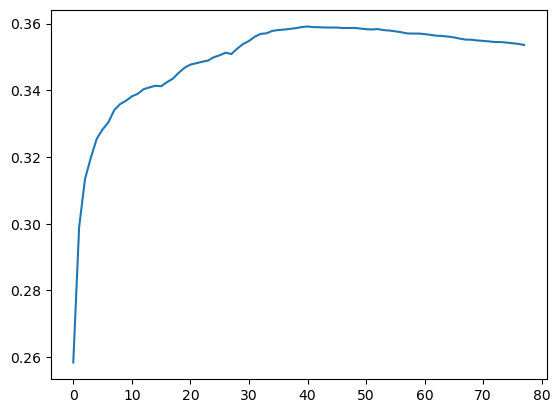

In [14]:
plt.plot(r2_all_array.mean(axis=0))

## performance analysis 

In [ ]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, device, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

/tmp/ipykernel_991847/3854074521.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r2 = np.corrcoef(torch.tensor(y_label).reshape(-1), prediction.detach().cpu().numpy().reshape(-1))[0,1]**2


[0.3536000867723633, 0.3515763975053103, 0.3683508062817459, 0.3484346178556437, 0.34928082851017367] 0.35424854738504735


In [14]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.35090627725752666, 0.34574344406430696, 0.35974062016998226, 0.33428008965083833, 0.34033690686505147] 0.34620146760154114


In [11]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.34676080861023645, 0.34001529593583874, 0.3581471294555243, 0.3291381092584444, 0.33525244364210216] 0.3418627573804292


In [31]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.34124305154047907, 0.33429049317908904, 0.3544312429865615, 0.3243167483168465, 0.33257982033558037] 0.33737227127171127


In [29]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3408887960003255, 0.3326585830346959, 0.353235820195374, 0.3224689266240401, 0.33105475080677427] 0.336061375332242


In [27]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls, fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3389598601008053, 0.32994289753704054, 0.3520788522282898, 0.32100578754095677, 0.32993013536173615] 0.33438350655376575


In [25]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3368769377897742, 0.32493789592481026, 0.34810858197283356, 0.3167857291405009, 0.3273988213573304] 0.33082159323704985


In [19]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3340978315116516, 0.3188870908666155, 0.34326885732316437, 0.31365926049244675, 0.32361275531649203] 0.3267051591020741


In [21]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.32825491942645535, 0.3122822984478497, 0.3355368097203841, 0.308689421236851, 0.319703338742639] 0.32089335751483583


In [23]:
r2_ls_fold = []
for fold_id in range(5):
    r2_ls_graph = get_model_performance_overall_combine(test_assay_ls, model_ls,fp_model, fold_id, 'test')
    r2_ls_fold.append(np.mean(r2_ls_graph))
print(r2_ls_fold,np.mean(r2_ls_fold))

[0.3198074552812821, 0.3036073623134336, 0.32826100750579623, 0.2996257923659276, 0.3074256168585508] 0.31174544686499805


## Bias-Variance decomposition